# SpamSMS dataset & random forests

In [1]:
# Import all useful libraries 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer # to convert input strings into numerical inputs
from sklearn.metrics import confusion_matrix, f1_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # optimizer for random forests

In [2]:
dat = pd.read_csv("spam.csv", encoding="latin-1") 

In [3]:
dat.head() # to display data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
dat = dat.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]) # to drop useless columns

In [5]:
dat.columns = ["class", "message"] # rename columns 

In [6]:
dat.head() # visualize the dataset with the renamed columns

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print("# of data: ", dat["message"].size) # total number of data

# of data:  5572


In [8]:
targets = dat.iloc[:, 0]
features = dat.iloc[:, 1]

In [9]:
# Convert the strings in the input into numerical arrays

# build a dictionary with a maximum of 3000 words and 
# convert everything into lowercase text

vec = CountVectorizer(max_features = 3000, lowercase = True) 

X = vec.fit_transform(features)

**Expected output format.** We could explain the output format making reference to a simple example. Suppose you wor with a dataset composed of 100 words and the $30^{th}$ message is "Hi, tomorrow I work". You aim at converting it by using a pre-built dictionary obtained with CountVectorizer, where the position of the four words is: *tomorrow: 12*, *I: 1*, *work: 40*, *Hi: 0*. For each word, the output format for the conversion of the $30^{th}$ message is:

$$
\mbox{(message index, word index)} \rightarrow  1
$$ 

The presence of 1 in the end stands for the probability score assigned to that word, namely 100\%. 

Therefore, the message "Hi, tomorrow I work" gets encoded as:
1. Hi $\rightarrow$ (30, 0)   1 
2. tomorrow $\rightarrow$ (30, 12)   1
3. I $\rightarrow$ (30, 1)   1 
4. work $\rightarrow$ (30, 40)   1

Such conversion transforms every uppercase letter into a lowercase character and removes punctuation by default.

In [11]:
# visualize the conversion of each message
print(X[0])

  (0, 2843)	1
  (0, 1164)	1
  (0, 2589)	1
  (0, 645)	1
  (0, 1462)	1
  (0, 2933)	1
  (0, 1173)	1
  (0, 526)	1
  (0, 1341)	1
  (0, 1865)	1
  (0, 368)	1
  (0, 742)	1
  (0, 1989)	1
  (0, 2749)	1
  (0, 1148)	1


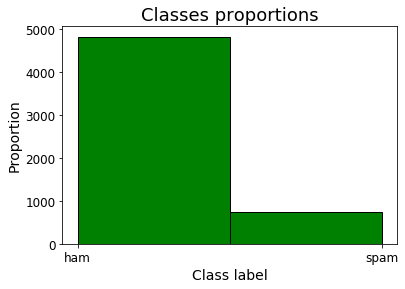

Spam proportion: 13.0 %
Non-spam proportion: 87.0 %


In [12]:
# Histogram to represent the proportion of each class in the training set

num_bins = 2
n, bins, patches = plt.hist(targets, num_bins, color="green", edgecolor="black")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Classes proportions", fontsize = 18)
plt.xlabel("Class label", fontsize = 14)
plt.ylabel("Proportion", fontsize = 14)

plt.show()

# Get the proportions of the two classes

nr_S = dat.loc[dat["class"] == "spam"].shape[0]
nr_NS = dat.loc[dat["class"] == "ham"].shape[0]

print("Spam proportion: {} %".format(round(100*nr_S/dat.shape[0],0)))
print("Non-spam proportion: {} %".format(round(100*nr_NS/dat.shape[0],0)))

The two classes are imbalanced. Therefore, we shall work specifying the option <class_weight="balanced"> in the random forest. This strategy allows to cope with imbalanced classes assigning a larger misclassification cost to the least frequent class.

In [13]:
# Optimization of the random forest varying the # of trees in the forest and the max depth of each tree
# The option <criterion = "entropy"> carries out the model optimization by minimizing the Shannon entropy of the data

def rforest_param_selection(X, y, nfolds):
    param_grid = {"n_estimators": [50, 100, 200], "max_depth": [10, 20, 30, 40]}
    rf_model = RandomForestClassifier(criterion = "entropy", class_weight = "balanced")
    grid_search = GridSearchCV(rf_model, param_grid, cv=nfolds)
    grid_search.fit(X, y)
    pred_targets = grid_search.predict(X)
    return (grid_search.best_params_, round(grid_search.best_score_,2), confusion_matrix(y, pred_targets),
           round(f1_score(y, pred_targets, average = "micro"),2))

In [14]:
print("Parameters of the best model: {}".format(rforest_param_selection(X, targets, 10)[0]))
print("Mean accuracy of the best model: {} %".format(rforest_param_selection(X, targets, 10)[1]*100))
print("Confusion matrix: {}".format(rforest_param_selection(X, targets, 10)[2]))
print("F-measure: {}".format(rforest_param_selection(X, targets, 10)[3]))

Parameters of the best model: {'max_depth': 20, 'n_estimators': 200}
Mean accuracy of the best model: 98.0 %
Confusion matrix: [[4824    1]
 [  60  687]]
F-measure: 0.99
